In [1]:
import numpy as np
import pandas as pd
import math
import mantel
import matplotlib.pyplot as plt 
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.stats import t, pearsonr
from sklearn.utils import shuffle
import igraph
from igraph import Graph, GraphBase
from itertools import permutations
from scipy import spatial, stats
from scipy.optimize import quadratic_assignment
import itertools
from joblib import Parallel, delayed
import scipy
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import seaborn as sns

### Functions

In [2]:
#Define functions
def triangles(g):
    cliques = GraphBase.cliques(g,min=3, max=3)
    result = [0] * GraphBase.vcount(g)
    for i, j, k in cliques:
        result[i] += 1
        result[j] += 1
        result[k] += 1
    return result

#### Create Files

In [3]:
#Define functions for Random Rewiring   
def create_statsfile_rewire(name):
    with open("../data/qap/stats_"+name+"_rand_rew_metrics.csv", "w") as outfile_stats:
        outfile_stats.write("rewirings,edges_betweenness,sd_edges_betweenness,pv_edges_betweenness,assortativity,sd_assortativity,pv_assortativity,betweenness,sd_betweenness,pv_betweenness,closeness,sd_closeness,pv_closeness,triangles_num,sd_triangles_num,pv_triangles_num,triangles_avg,sd_triangles_avg,pv_triangles_avg,local_clustering,sd_local_clustering,pv_local_clustering,global_clustering,sd_global_clustering,pv_global_clustering,avg_path_len,sd_avg_path_len,pv_avg_path_len\n")
        
def create_nulldistfile_rewire(name):
    with open("../data/qap/nulldist_"+name+"_rand_rew.csv", "w") as outfile_nulldist:
        outfile_nulldist.write("rewirings,simulations,observed_corr_coef,null_dist\n") 
        
def create_mantelfile_rewire(name):
    with open("../data/qap/mantel_"+name+"_rand_rew.csv", "w") as outfile_mantel:
        outfile_mantel.write("rewirings,simulations,p_value\n")

In [4]:
#Define functions for Shuffle    
def create_statsfile_shuffle(name):
    with open("../data/qap/stats_"+name+"_shuffle_metrics.csv", "w") as outfile_stats:
        outfile_stats.write("rewirings,edges_betweenness,sd_edges_betweenness,pv_edges_betweenness,assortativity,sd_assortativity,pv_assortativity,betweenness,sd_betweenness,pv_betweenness,closeness,sd_closeness,pv_closeness,triangles_num,sd_triangles_num,pv_triangles_num,triangles_avg,sd_triangles_avg,pv_triangles_avg,local_clustering,sd_local_clustering,pv_local_clustering,global_clustering,sd_global_clustering,pv_global_clustering,avg_path_len,sd_avg_path_len,pv_avg_path_len\n")
        
def create_nulldistfile_shuffle(name):
    with open("../data/qap/nulldist_"+name+"_shuffle.csv", "w") as outfile_nulldist:
        outfile_nulldist.write("rewirings,simulations,observed_corr_coef,null_dist\n")
        
def create_mantelfile_shuffle(name):
    with open("../data/qap/mantel_"+name+"_shuffle.csv", "w") as outfile_mantel:
        outfile_mantel.write("rewirings,simulations,p_value\n")

#### Simulations

In [5]:
def expanded_random_rewiring(network, count, rews, simulations, file_stats, file_nulldist, file_mantel, name): 
    warnings.filterwarnings('ignore')
    network_ig = network
    network = np.array(network.get_adjacency().data)

    # Calculate the observed correlation coefficient
    observed_corr_coef = np.corrcoef(network.flatten(), network[np.arange(network.shape[0])].flatten())[0, 1]

    edges_betweenness = np.zeros(simulations)
    betweenness = np.zeros(simulations)
    closeness = np.zeros(simulations)
    assortativity = np.zeros(simulations)
    triangles_num = np.zeros(simulations)
    triangles_avg = np.zeros(simulations)
    local_clustering = np.zeros(simulations)
    global_clustering = np.zeros(simulations)
    avg_path_len = np.zeros(simulations)
    
    n = network.shape[0]
    permuted_B_ig = GraphBase.copy(network_ig)

    # Generate the null distribution of correlation coefficients
    for sim in range(simulations):              
        GraphBase.rewire(permuted_B_ig, n=rews)
        permuted_B = np.array(permuted_B_ig.get_adjacency().data)
        
        edges_betweenness[sim] = np.nanmean(permuted_B_ig.edge_betweenness())
        betweenness[sim] = np.nanmean(permuted_B_ig.betweenness())
        closeness[sim] = np.nanmean(permuted_B_ig.closeness())
        assortativity[sim] = permuted_B_ig.assortativity_degree()
        triangles_num[sim] = len(permuted_B_ig.list_triangles())
        triangles_avg[sim] = np.nanmean(triangles(permuted_B_ig))
        local_clustering[sim] = permuted_B_ig.transitivity_avglocal_undirected()
        global_clustering[sim] = permuted_B_ig.transitivity_undirected()
        avg_path_len[sim] = permuted_B_ig.average_path_length()
        
        permuted_idx = quadratic_assignment(network, permuted_B, options={'maximize': True})['col_ind']
        null_dist = np.corrcoef(network.flatten(), network[permuted_idx].flatten())[0, 1]
        mantel = mantel_test(network, permuted_B, option='normal', perms=1)
        
        #output data
        with open(file_nulldist, 'a+') as outfile_nulldist:
            outfile_nulldist.write(str(rews) + "," + #rewiring
                          str(sim) + "," + #simulation
                          str(observed_corr_coef) + "," + #simulation
                          str(null_dist) + "\n") #null_dist  
        
        with open(file_mantel, 'a+') as outfile_mantel:
            outfile_mantel.write(str(rews) + "," + #rewiring
                          str(sim) + "," + #simulation
                          str(mantel) + "\n") #mantel  
        
    #output data
    with open(file_stats, 'a+') as outfile_stats:
        outfile_stats.write(str(rews) + "," + #rewirings
                      #Edge_Betweenness
                      str(np.mean(edges_betweenness)) + "," +
                      str(np.std(edges_betweenness)) + "," +
                      str(scipy.stats.ttest_1samp(edges_betweenness, popmean=np.nanmean(network_ig.edge_betweenness()), nan_policy='omit')[1]) + "," + #p-value
                      #Assortativity
                      str(np.mean(assortativity)) + "," +
                      str(np.std(assortativity)) + "," +
                      str(scipy.stats.ttest_1samp(assortativity, popmean=network_ig.assortativity_degree(), nan_policy='omit')[1]) + "," + #p-value
                      #Avg betweenness
                      str(np.mean(betweenness)) + "," +
                      str(np.std(betweenness)) + "," +
                      str(scipy.stats.ttest_1samp(assortativity, popmean=np.nanmean(network_ig.betweenness()), nan_policy='omit')[1])+ "," + #p-value
                      #Avg closeness
                      str(np.mean(closeness)) + "," +
                      str(np.std(closeness)) + "," +
                      str(scipy.stats.ttest_1samp(assortativity, popmean=np.nanmean(network_ig.closeness()), nan_policy='omit')[1])+ "," + #p-value                   
                      #Number of Triangles
                      str(np.mean(triangles_num)) + "," +
                      str(np.std(triangles_num)) + "," +
                      str(scipy.stats.ttest_1samp(assortativity, popmean=len(network_ig.list_triangles()), nan_policy='omit')[1])+ "," + #p-value
                      #Average of Triangles
                      str(np.mean(triangles_avg)) + "," +
                      str(np.std(triangles_avg)) + "," +
                      str(scipy.stats.ttest_1samp(assortativity, popmean=np.nanmean(triangles(network_ig)), nan_policy='omit')[1])+ "," + #p-value
                      #Average Local Clustering
                      str(np.mean(local_clustering)) + "," +
                      str(np.std(local_clustering)) + "," +
                      str(scipy.stats.ttest_1samp(assortativity, popmean=network_ig.transitivity_avglocal_undirected(), nan_policy='omit')[1])+ "," + #p-value
                      #Global Clustreing
                      str(np.mean(global_clustering)) + "," +
                      str(np.std(global_clustering)) + "," +
                      str(scipy.stats.ttest_1samp(assortativity, popmean=network_ig.transitivity_undirected(), nan_policy='omit')[1])+ "," + #p-value
                      #Average Path Length
                      str(np.mean(avg_path_len)) + "," +
                      str(np.std(avg_path_len)) + "," +
                      str(scipy.stats.ttest_1samp(assortativity, popmean=network_ig.average_path_length(), nan_policy='omit')[1])+ "\n") #p-value

In [6]:
def expanded_shuffle(network, simulations, file_stats, file_nulldist, file_mantel, name):  
    network_ig = network
    network = np.array(network.get_adjacency().data)

    # Calculate the observed correlation coefficient
    observed_corr_coef = np.corrcoef(network.flatten(), network[np.arange(network.shape[0])].flatten())[0, 1]

    edges_betweenness = np.zeros(simulations)
    betweenness = np.zeros(simulations)
    closeness = np.zeros(simulations)
    assortativity = np.zeros(simulations)
    triangles_num = np.zeros(simulations)
    triangles_avg = np.zeros(simulations)
    local_clustering = np.zeros(simulations)
    global_clustering = np.zeros(simulations)
    avg_path_len = np.zeros(simulations)
    
    n = network.shape[0]
    permuted_B_ig = GraphBase.copy(network_ig)
    
    # Generate the null distribution of correlation coefficients
    for sim in range(simulations):              
        g_shuffle = GraphBase.copy(permuted_B_ig).get_adjacency()
        g_shuffle = np.array(list(g_shuffle))
        np.random.shuffle(g_shuffle)
        g_shuffle = igraph.Graph.Adjacency((g_shuffle > 0).tolist())
        
        permuted_B = np.array(g_shuffle.get_adjacency().data)
        
        edges_betweenness[sim] = np.nanmean(g_shuffle.edge_betweenness())
        betweenness[sim] = np.nanmean(g_shuffle.betweenness())
        closeness[sim] = np.nanmean(g_shuffle.closeness())
        assortativity[sim] = g_shuffle.assortativity_degree()
        triangles_num[sim] = len(g_shuffle.list_triangles())
        triangles_avg[sim] = np.nanmean(triangles(g_shuffle))
        local_clustering[sim] = g_shuffle.transitivity_avglocal_undirected()
        global_clustering[sim] = g_shuffle.transitivity_undirected()
        avg_path_len[sim] = g_shuffle.average_path_length()
        
        permuted_idx = quadratic_assignment(network, permuted_B, options={'maximize': True})['col_ind']
        null_dist = np.corrcoef(network.flatten(), network[permuted_idx].flatten())[0, 1]
        mantel = mantel_test(network, permuted_B, option='normal', perms=1)
        
        #output data
        with open(file_nulldist, 'a+') as outfile_nulldist:
            outfile_nulldist.write(str(sim) + "," + #simulation
                          str(observed_corr_coef) + "," + #simulation
                          str(null_dist) + "\n") #null_dist 
        
        with open(file_mantel, 'a+') as outfile_mantel:
            outfile_mantel.write(str(sim) + "," + #rewiring
                          str(sim) + "," + #simulation
                          str(mantel) + "\n") #mantel 
        
    #output data
    with open(file_stats, 'a+') as outfile_stats:
        outfile_stats.write(str(sim) + "," + #rewirings
                      #Edge_Betweenness
                      str(np.mean(edges_betweenness)) + "," +
                      str(np.std(edges_betweenness)) + "," +
                      str(scipy.stats.ttest_1samp(edges_betweenness, popmean=np.nanmean(network_ig.edge_betweenness()), nan_policy='omit')[1]) + "," + #p-value
                      #Assortativity
                      str(np.mean(assortativity)) + "," +
                      str(np.std(assortativity)) + "," +
                      str(scipy.stats.ttest_1samp(assortativity, popmean=network_ig.assortativity_degree(), nan_policy='omit')[1]) + "," + #p-value
                      #Avg betweenness
                      str(np.mean(betweenness)) + "," +
                      str(np.std(betweenness)) + "," +
                      str(scipy.stats.ttest_1samp(assortativity, popmean=np.nanmean(network_ig.betweenness()), nan_policy='omit')[1])+ "," + #p-value
                      #Avg closeness
                      str(np.mean(closeness)) + "," +
                      str(np.std(closeness)) + "," +
                      str(scipy.stats.ttest_1samp(assortativity, popmean=np.nanmean(network_ig.closeness()), nan_policy='omit')[1])+ "," + #p-value                   
                      #Number of Triangles
                      str(np.mean(triangles_num)) + "," +
                      str(np.std(triangles_num)) + "," +
                      str(scipy.stats.ttest_1samp(assortativity, popmean=len(network_ig.list_triangles()), nan_policy='omit')[1])+ "," + #p-value
                      #Average of Triangles
                      str(np.mean(triangles_avg)) + "," +
                      str(np.std(triangles_avg)) + "," +
                      str(scipy.stats.ttest_1samp(assortativity, popmean=np.nanmean(triangles(network_ig)), nan_policy='omit')[1])+ "," + #p-value
                      #Average Local Clustering
                      str(np.mean(local_clustering)) + "," +
                      str(np.std(local_clustering)) + "," +
                      str(scipy.stats.ttest_1samp(assortativity, popmean=network_ig.transitivity_avglocal_undirected(), nan_policy='omit')[1])+ "," + #p-value
                      #Global Clustreing
                      str(np.mean(global_clustering)) + "," +
                      str(np.std(global_clustering)) + "," +
                      str(scipy.stats.ttest_1samp(assortativity, popmean=network_ig.transitivity_undirected(), nan_policy='omit')[1])+ "," + #p-value
                      #Average Path Length
                      str(np.mean(avg_path_len)) + "," +
                      str(np.std(avg_path_len)) + "," +
                      str(scipy.stats.ttest_1samp(assortativity, popmean=network_ig.average_path_length(), nan_policy='omit')[1])+ "\n") #p-value

In [7]:
def expanded_controlled_rewiring(network, iterations, simulations, file_stats, file_nulldist, file_mantel):  
    from igraph import Graph
    import random
   
    edges_betweenness = np.zeros((iterations+1, simulations))
    betweenness = np.zeros((iterations+1, simulations))
    closeness = np.zeros((iterations+1, simulations))
    assortativity = np.zeros((iterations+1, simulations))
    triangles_num = np.zeros((iterations+1, simulations))
    triangles_avg = np.zeros((iterations+1, simulations))
    local_clustering = np.zeros((iterations+1, simulations))
    global_clustering = np.zeros((iterations+1, simulations))
    avg_path_len = np.zeros((iterations+1, simulations))
    null_dist = np.zeros((iterations+1, simulations))
    mantel = np.zeros((iterations+1, simulations))
    
    edges_betweenness[0,:] = np.nanmean(network.edge_betweenness())
    betweenness[0,:] = np.nanmean(network.betweenness())
    closeness[0,:] = np.nanmean(network.closeness())
    assortativity[0,:] = network.assortativity_degree()
    triangles_num[0,:] = len(network.list_triangles())
    triangles_avg[0,:] = np.nanmean(triangles(network))
    local_clustering[0,:] = network.transitivity_avglocal_undirected()
    global_clustering[0,:] = network.transitivity_undirected()
    avg_path_len[0,:] = network.average_path_length()
    mantel[0,:] = 1
    
    # Calculate the observed correlation coefficient
    network_adj = np.array(network.get_adjacency().data)
    observed_corr_coef = np.corrcoef(network_adj.flatten(), network_adj[np.arange(network_adj.shape[0])].flatten())[0, 1]
    null_dist[0,:] = observed_corr_coef
    
    sim = 0
    while sim < simulations:
        print(sim)
        network_copy = network.copy()
               
        for it in range(0, iterations, int(iterations*0.05)):
            id_nodes = list(np.arange(it,int(iterations*0.05)+it))
            
            id_nodes = list(filter(lambda num: num < network.ecount(), id_nodes))
            
            if len(id_nodes) == 1: 
                id_nodes.append(id_nodes[0]-1)
            
            #print(len(id_nodes))
           
            for id_n in id_nodes: 
                source = []
                target = []
                ids = []
                for edge in network_copy.es:
                    source.append(edge.source)
                    target.append(edge.target)
                    ids.append(network_copy.get_eid(edge.source,edge.target))
                edges = pd.DataFrame(ids, columns = ['ids'])
                edges['source'] = source
                edges['target'] = target
                edges['betweenness'] = network_copy.edge_betweenness()
                edges = edges.sort_values(by = 'betweenness')
                edges = edges.reset_index(drop=True)
                
                j,k  = random.sample(id_nodes, k = 2)
                id1,id2 = edges['ids'].iloc[j], edges['ids'].iloc[k]

                source_edge1 = edges['source'].iloc[j]
                source_edge2 = edges['source'].iloc[k]

                initial_target_edge1 = edges['target'].iloc[j]
                initial_target_edge2 = edges['target'].iloc[k]

                final_target_edge1 = initial_target_edge2
                final_target_edge2 = initial_target_edge1

                network_copy.add_edge(source_edge1,final_target_edge1)
                network_copy.add_edge(source_edge2,final_target_edge2)

                network_copy.delete_edges([(source_edge1,initial_target_edge1)])
                network_copy.delete_edges([(source_edge2,initial_target_edge2)])

                #metrics[id_n+1, sim] = network_copy.assortativity_degree()
                
                edges_betweenness[id_n+1, sim] = np.nanmean(network_copy.edge_betweenness())
                betweenness[id_n+1, sim] = np.nanmean(network_copy.betweenness())
                closeness[id_n+1, sim] = np.nanmean(network_copy.closeness())
                assortativity[id_n+1, sim] = network_copy.assortativity_degree()
                triangles_num[id_n+1, sim] = len(network_copy.list_triangles())
                triangles_avg[id_n+1, sim] = np.nanmean(triangles(network_copy))
                local_clustering[id_n+1, sim] = network_copy.transitivity_avglocal_undirected()
                global_clustering[id_n+1, sim] = network_copy.transitivity_undirected()
                avg_path_len[id_n+1, sim] = network_copy.average_path_length()
                
                permuted_B = np.array(network_copy.get_adjacency().data)
        
                permuted_idx = quadratic_assignment(network_adj, permuted_B, options={'maximize': True})['col_ind']
                null_dist[id_n+1, sim] = np.corrcoef(permuted_B.flatten(), permuted_B[permuted_idx].flatten())[0, 1]
                #print(mantel_test(network_adj, permuted_B, option='normal', perms=1000))
                #mantel[id_n+1, sim] = mantel_test(network_adj, permuted_B, option='normal', perms=1)
                
        sim = sim + 1
        #print(sim)
         
    edges_betweenness_mean = pd.DataFrame(np.mean(edges_betweenness, axis = 1), columns = ['edges_betweenness'])
    edges_betweenness_std = pd.DataFrame(np.std(edges_betweenness, axis = 1), columns = ['sd_edges_betweenness'])
    edges_betweenness_pv = pd.DataFrame(scipy.stats.ttest_1samp(edges_betweenness, popmean=edges_betweenness[0,0], axis=1, nan_policy='omit')[1], columns = ['pv_edges_betweenness'])
        
    betweenness_mean = pd.DataFrame(np.mean(betweenness, axis = 1), columns = ['betweenness'])
    betweenness_std = pd.DataFrame(np.std(betweenness, axis = 1), columns = ['sd_betweenness'])
    betweenness_pv = pd.DataFrame(scipy.stats.ttest_1samp(betweenness, popmean=betweenness[0,0], axis=1, nan_policy='omit')[1], columns = ['pv_betweenness'])

    closeness_mean = pd.DataFrame(np.mean(closeness, axis = 1), columns = ['closeness'])
    closeness_std = pd.DataFrame(np.std(closeness, axis = 1), columns = ['sd_closeness'])
    closeness_pv = pd.DataFrame(scipy.stats.ttest_1samp(closeness, popmean=closeness[0,0], axis = 1, nan_policy='omit')[1], columns = ['pv_closeness'])

    assortativity_mean = pd.DataFrame(np.mean(assortativity, axis = 1), columns = ['assortativity'])
    assortativity_std = pd.DataFrame(np.std(assortativity, axis = 1), columns = ['sd_assortativity'])
    assortativity_pv = pd.DataFrame(scipy.stats.ttest_1samp(assortativity, popmean=assortativity[0,0], axis = 1, nan_policy='omit')[1], columns = ['pv_assortativity'])

    triangles_num_mean = pd.DataFrame(np.mean(triangles_num, axis = 1), columns = ['triangles_num'])
    triangles_num_std = pd.DataFrame(np.std(triangles_num, axis = 1), columns = ['sd_triangles_num'])
    triangles_num_pv = pd.DataFrame(scipy.stats.ttest_1samp(triangles_num, popmean=triangles_num[0,0], axis = 1, nan_policy='omit')[1], columns = ['pv_triangles_num'])

    triangles_avg_mean = pd.DataFrame(np.mean(triangles_avg, axis = 1), columns = ['triangles_avg'])
    triangles_avg_std = pd.DataFrame(np.std(triangles_avg, axis = 1), columns = ['sd_triangles_avg'])
    triangles_avg_pv = pd.DataFrame(scipy.stats.ttest_1samp(triangles_avg, popmean=triangles_avg[0,0], axis = 1, nan_policy='omit')[1], columns = ['pv_triangles_avg'])

    local_clustering_mean = pd.DataFrame(np.mean(local_clustering, axis = 1), columns = ['local_clustering'])
    local_clustering_std = pd.DataFrame(np.std(local_clustering, axis = 1), columns = ['sd_local_clustering'])
    local_clustering_pv = pd.DataFrame(scipy.stats.ttest_1samp(local_clustering, popmean=local_clustering[0,0], axis = 1, nan_policy='omit')[1], columns = ['pv_local_clustering'])

    global_clustering_mean = pd.DataFrame(np.mean(global_clustering, axis = 1), columns = ['global_clustering'])
    global_clustering_std = pd.DataFrame(np.std(global_clustering, axis = 1), columns = ['sd_global_clustering'])
    global_clustering_pv = pd.DataFrame(scipy.stats.ttest_1samp(global_clustering, popmean=global_clustering[0,0], axis = 1, nan_policy='omit')[1], columns = ['pv_global_clustering'])

    avg_path_len_mean = pd.DataFrame(np.mean(avg_path_len, axis = 1), columns = ['avg_path_len'])
    avg_path_len_std = pd.DataFrame(np.std(avg_path_len, axis = 1), columns = ['sd_avg_path_len'])
    avg_path_len_pv = pd.DataFrame(scipy.stats.ttest_1samp(avg_path_len, popmean=avg_path_len[0,0], axis = 1, nan_policy='omit')[1], columns = ['pv_avg_path_len'])

    p_values = pd.DataFrame(np.mean(avg_path_len, axis = 1), columns = ['avg_path_len'])
    
    metrics_df = pd.concat([edges_betweenness_mean, edges_betweenness_std, edges_betweenness_pv,
                           betweenness_mean, betweenness_std,  betweenness_pv,
                           closeness_mean, closeness_std,  closeness_pv,
                           assortativity_mean, assortativity_std, assortativity_pv,
                           triangles_num_mean, triangles_num_std, triangles_num_pv,
                           triangles_avg_mean, triangles_avg_std, triangles_avg_pv,
                           local_clustering_mean, local_clustering_std, local_clustering_pv,
                           global_clustering_mean, global_clustering_std, global_clustering_pv,
                           avg_path_len_mean, avg_path_len_std, avg_path_len_pv], axis=1)
    
    metrics_df.to_csv(file_stats)
    pd.DataFrame(null_dist).to_csv(file_nulldist)
   # pd.DataFrame(mantel).to_csv(file_mantel)

In [8]:
def mantel_test(matrix1, matrix2, option='normal', perms=1000):
    n = matrix1.shape[0]  # set n to the size of the matrices
    # Convert the distance matrices to condensed form
    X = squareform(pdist(matrix1))
    Y = squareform(pdist(matrix2))

    # Check that X and Y are valid distance matrices.
    if (
        spatial.distance.is_valid_dm(np.nan_to_num(X)) == False
        and spatial.distance.is_valid_y(X) == False
    ):
        raise ValueError("X is not a valid condensed or redundant distance matrix")
    if (
        spatial.distance.is_valid_dm(np.nan_to_num(Y)) == False
        and spatial.distance.is_valid_y(Y) == False
    ):
        raise ValueError("Y is not a valid condensed or redundant distance matrix")

    # If X or Y is a redundant distance matrix, reduce it to a condensed distance matrix.
    if len(X.shape) == 2:
        X = spatial.distance.squareform(X, force="tovector", checks=False)
    if len(Y.shape) == 2:
        Y = spatial.distance.squareform(Y, force="tovector", checks=False)

    # Check for size equality.
    if len(X) != len(Y):
        raise ValueError("X and Y are not of equal size")

    # Check for minimum size.
    if len(X) < 3:
        raise ValueError("X and Y should represent at least 3 objects")

    # Check finiteness of X and Y
    if not np.isfinite(X).all():
        raise ValueError(
            "X cannot contain NaNs (but Y may contain NaNs, so consider reordering X and Y)"
        )
    finite_Y = np.isfinite(Y)

    # Calculate the X and Y residuals, which will be used to compute the
    # covariance under each permutation.
    X_residuals = X - np.mean(X[finite_Y])
    Y_residuals = Y - np.mean(Y[finite_Y])

    # Expand the Y residuals to a redundant matrix.
    X_residuals_as_matrix = spatial.distance.squareform(X_residuals, force="tomatrix", checks=False)
    Y_residuals_as_matrix = spatial.distance.squareform(Y_residuals, force="tomatrix", checks=False)
    
    # Perform the Mantel test
    if option == 'shuffle':
        simulations = 250
        #Initialize 
        correlations = np.zeros(simulations)
        covariances = np.zeros(simulations)  # store the covariances for each permutation

        # initialize arrays to store results
        Y_residuals_permuted = np.zeros((n**2 - n) // 2)  # store permuted residuals as a 1D array
      
        pvalue = np.zeros(simulations)
        # loop over each permutation
        for i in range(1, simulations):
            print(i)
            # permute the residuals matrix using the shuffled indices
            Y_residuals_as_matrix_permuted = Y_residuals_as_matrix.copy()
            np.random.shuffle(Y_residuals_as_matrix_permuted)

            # convert the permuted residuals matrix to a 1D array
            spatial.distance._distance_wrap.to_vector_from_squareform_wrap(
                Y_residuals_as_matrix_permuted, Y_residuals_permuted
            )

            # compute the covariance between the X residuals and the permuted Y residuals
            covariances[i] = (X_residuals * Y_residuals_permuted).sum()

            # compute the denominator of the test statistic
            denominator = np.sqrt(sum(X_residuals**2) * sum(Y_residuals_permuted**2))

            # return the covariances divided by the denominator
            correlations[i] = covariances[i] / denominator
            correlations[0] = sum(X_residuals[finite_Y] * Y_residuals[finite_Y]) / np.sqrt(
                sum(X_residuals[finite_Y] ** 2) * sum(Y_residuals[finite_Y] ** 2)
            )  # compute veridical correlation and place in positon 0

            pvalue[i] = sum(abs(correlations[0:i]) >= abs(correlations[0])) / i
            
        print(correlations)

    if option == 'normal':
        #Initialize 
        correlations = np.zeros(perms)
        covariances = np.zeros(perms)  # store the covariances for each permutation

        # initialize arrays to store results
        Y_residuals_permuted = np.zeros((n**2 - n) // 2)  # store permuted residuals as a 1D array
        pvalue = np.zeros(perms)
        # create an array of indices to shuffle for each permutation
        order = np.arange(n)

        # loop over each permutation
        for i in range(1, perms):
            #print(i)
            # shuffle the indices to generate a new permutation
            np.random.shuffle(order)

            # permute the residuals matrix using the shuffled indices
            Y_residuals_as_matrix_permuted = Y_residuals_as_matrix[order, :][:, order]

            # convert the permuted residuals matrix to a 1D array
            spatial.distance._distance_wrap.to_vector_from_squareform_wrap(
                Y_residuals_as_matrix_permuted, Y_residuals_permuted
            )

            # compute the covariance between the X residuals and the permuted Y residuals
            covariances[i] = (X_residuals * Y_residuals_permuted).sum()

            # compute the denominator of the test statistic
            denominator = np.sqrt(sum(X_residuals**2) * sum(Y_residuals_permuted**2))

            # return the covariances divided by the denominator
            correlations[i] = covariances[i] / denominator
            correlations[0] = sum(X_residuals[finite_Y] * Y_residuals[finite_Y]) / np.sqrt(
                sum(X_residuals[finite_Y] ** 2) * sum(Y_residuals[finite_Y] ** 2)
            )  # compute veridical correlation and place in positon 0
            pvalue[i] = sum(abs(correlations[0:i]) >= abs(correlations[0])) / i
            
    return sum(abs(correlations[0:perms]) >= abs(correlations[0]))

#### Plots

In [9]:
#Define function for Plotting    
def PanelPlot(name, simulations, rewirings):
    fig, ((ax1, ax2, ax3), 
          (ax4, ax5, ax6), 
          (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(15, 10), sharey=False)

    sns.set()
    sns.set_style("whitegrid", {'axes.grid' : False})
    
    x_max = len(rewirings)
    df = pd.read_csv("../data/qap/stats_"+name_network+"_cont_rew_metrics.csv", sep = ',')
    df = df.rename(columns={'Unnamed: 0': 'rewirings'})
    #indices = range(0, len(df), 100)
    #df = pd.DataFrame(df)
    #df = df.iloc[indices] 
    df = df.sort_values(by = 'rewirings')
    df = df.reset_index(drop=True)
    df = df[0:len(rewirings)]
    df2 = pd.read_csv("../data/qap/stats_"+name_network+"_rand_rew_metrics.csv", sep = ',')
    df2 = df2.sort_values(by = 'rewirings')
    df2 = df2.reset_index(drop=True)
    df3 = pd.read_csv("../data/qap/stats_"+name_network+"_shuffle_metrics.csv", sep = ',')
    
    ax1.x = df["rewirings"]
    print(len(ax1.x))
    ax1.mean_1 = np.repeat(df2["edges_betweenness"][0],len(rewirings))
    ax1.mean_2 = df["edges_betweenness"]
    ax1.mean_3 = df2["edges_betweenness"]
    print(len(ax1.mean_1))
    ax1.mean_4 = np.repeat(df3['edges_betweenness'][0],len(rewirings))
    ax1.std_rew = df["sd_edges_betweenness"]
    ax1.std_rand = df2["sd_edges_betweenness"]
    ax1.std_shuf = np.repeat(df3["sd_edges_betweenness"][0],len(df["rewirings"]))
    ax1.set(xlim=(0, x_max))
    ax1.plot(ax1.x, ax1.mean_1, 'k-', label='Original Network')
    ax1.fill_between(ax1.x, ax1.mean_1, ax1.mean_1, color = 'k', alpha=0.2)
    ax1.plot(ax1.x, ax1.mean_2, 'k--', label= str(simulations)+' Controlled Rewirings')
    ax1.fill_between(ax1.x, ax1.mean_2 - ax1.std_rew, ax1.mean_2 + ax1.std_rew, color='k', alpha=0.2)
    ax1.plot(ax1.x, ax1.mean_3, color = 'silver', linestyle = '-', label= str(simulations)+' Random Rewirings')
    ax1.fill_between(ax1.x, ax1.mean_3 - ax1.std_rand, ax1.mean_3 + ax1.std_rand, color = 'silver', alpha=0.2)
    ax1.plot(ax1.x, ax1.mean_4, color = 'lightgrey', linestyle = '-.', label= str(simulations)+' Shuffles')
    ax1.fill_between(ax1.x, ax1.mean_4 - ax1.std_shuf, ax1.mean_4 + ax1.std_shuf, color = 'lightgrey', alpha=0.2)
    ax1.labs = [item.get_text() for item in ax1.get_yticklabels()]
    ax1.set_yticks(np.unique(np.array(list([round(float(b.replace('−', '-')), 2) for b in ax1.labs]))).tolist())
    ax1.set_title('Average Edge Betweenness', fontsize=12)
    
    ax2.x = df["rewirings"][0:len(rewirings)]
    ax2.mean_1 = np.repeat(df2["betweenness"][0],len(df["rewirings"]))
    ax2.mean_2 = df["betweenness"][0:len(rewirings)]
    ax2.mean_3 = df2["betweenness"][0:len(rewirings)]
    ax2.mean_4 = np.repeat(df3['betweenness'][0],len(df["rewirings"]))
    ax2.std_rew = df["sd_betweenness"][0:len(rewirings)]
    ax2.std_rand = df2["sd_betweenness"][0:len(rewirings)]
    ax2.std_shuf = np.repeat(df3["sd_betweenness"][0],len(df["rewirings"]))    
    ax2.set(xlim=(0, x_max))
    ax2.plot(ax2.x, ax2.mean_1, 'k-')
    ax2.fill_between(ax2.x, ax2.mean_1, ax2.mean_1, color = 'k', alpha=0.2)
    ax2.plot(ax2.x, ax2.mean_2, 'k--', label= str(simulations)+' simulations')
    ax2.fill_between(ax2.x, ax2.mean_2 - ax2.std_rew, ax2.mean_2 + ax2.std_rew, color='k', alpha=0.2)
    ax2.plot(ax2.x, ax2.mean_3, color = 'silver', linestyle = '-', label= str(simulations)+' simulations')
    ax2.fill_between(ax2.x, ax2.mean_3 - ax2.std_rand, ax2.mean_3 + ax2.std_rand, color = 'silver', alpha=0.2)
    ax2.plot(ax2.x, ax2.mean_4, color = 'lightgrey', linestyle = '-.', label= str(simulations)+' simulations')
    ax2.fill_between(ax2.x, ax2.mean_4 - ax2.std_shuf, ax2.mean_4 + ax2.std_shuf, color = 'lightgrey', alpha=0.2)
    ax2.labs = [item.get_text() for item in ax2.get_yticklabels()]
    ax2.set_yticks(np.unique(np.array(list([round(float(b.replace('−', '-')), 2) for b in ax2.labs]))).tolist())
    ax2.set_title('Average Betweenness', fontsize=12)

    ax3.x = df["rewirings"]
    ax3.mean_1 = np.repeat(df2["closeness"][0],len(df["rewirings"]))
    ax3.mean_2 = df["closeness"]
    ax3.mean_3 = df2["closeness"]
    ax3.mean_4 = np.repeat(df3['closeness'][0],len(df["rewirings"]))
    ax3.std_rew = df["sd_closeness"]
    ax3.std_rand = df2["sd_closeness"]
    ax3.std_shuf = np.repeat(df3["sd_closeness"][0],len(df["rewirings"]))    
    ax3.set(xlim=(0, x_max))
    ax3.plot(ax3.x, ax3.mean_1, 'k-')
    ax3.fill_between(ax3.x, ax3.mean_1, ax3.mean_1, color = 'k', alpha=0.2)
    ax3.plot(ax3.x, ax3.mean_2, 'k--', label= str(simulations)+' simulations')
    ax3.fill_between(ax3.x, ax3.mean_2 - ax3.std_rew, ax3.mean_2 + ax3.std_rew, color='k', alpha=0.2)
    ax3.plot(ax3.x, ax3.mean_3, color = 'silver', linestyle = '-', label= str(simulations)+' simulations')
    ax3.fill_between(ax3.x, ax3.mean_3 - ax3.std_rand, ax3.mean_3 + ax3.std_rand, color = 'silver', alpha=0.2)
    ax3.plot(ax3.x, ax3.mean_4, color = 'lightgrey', linestyle = '-.', label= str(simulations)+' simulations')
    ax3.fill_between(ax3.x, ax3.mean_4 - ax3.std_shuf, ax3.mean_4 + ax3.std_shuf, color = 'lightgrey', alpha=0.2)
    ax3.labs = [item.get_text() for item in ax3.get_yticklabels()]
    ax3.set_yticks(np.unique(np.array(list([round(float(b.replace('−', '-')), 2) for b in ax3.labs]))).tolist())
    ax3.set_title('Average Closeness', fontsize=12)

    ax4.x = df["rewirings"]
    ax4.mean_1 = np.repeat(df2["assortativity"][0],len(df["rewirings"]))
    ax4.mean_2 = df["assortativity"]
    ax4.mean_3 = df2["assortativity"]
    ax4.mean_4 = np.repeat(df3['assortativity'][0],len(df["rewirings"]))
    ax4.std_rew = df["sd_assortativity"]
    ax4.std_rand = df2["sd_assortativity"]
    ax4.std_shuf = np.repeat(df3["sd_assortativity"][0],len(df["rewirings"]))    
    ax4.set(xlim=(0, x_max))
    ax4.plot(ax4.x, ax4.mean_1, 'k-')
    ax4.fill_between(ax4.x, ax4.mean_1, ax4.mean_1, color = 'k', alpha=0.2)
    ax4.plot(ax4.x, ax4.mean_2, 'k--', label= str(simulations)+' simulations')
    ax4.fill_between(ax4.x, ax4.mean_2 - ax4.std_rew, ax4.mean_2 + ax4.std_rew, color='k', alpha=0.2)
    ax4.plot(ax4.x, ax4.mean_3, color = 'silver', linestyle = '-', label= str(simulations)+' simulations')
    ax4.fill_between(ax4.x, ax4.mean_3 - ax4.std_rand, ax4.mean_3 + ax4.std_rand, color = 'silver', alpha=0.2)
    ax4.plot(ax4.x, ax4.mean_4, color = 'lightgrey', linestyle = '-.', label= str(simulations)+' simulations')
    ax4.fill_between(ax4.x, ax4.mean_4 - ax4.std_shuf, ax4.mean_4 + ax4.std_shuf, color = 'lightgrey', alpha=0.2)
    ax4.labs = [item.get_text() for item in ax4.get_yticklabels()]
    ax4.set_yticks(np.unique(np.array(list([round(float(b.replace('−', '-')), 2) for b in ax4.labs]))).tolist())
    ax4.set_title('Assortativity', fontsize=12)

    ax5.x = df["rewirings"]
    ax5.mean_1 = np.repeat(df2["triangles_num"][0],len(df["rewirings"]))
    ax5.mean_2 = df["triangles_num"]
    ax5.mean_3 = df2["triangles_num"]
    ax5.mean_4 = np.repeat(df3['triangles_num'][0],len(df["rewirings"]))
    ax5.std_rew = df["sd_triangles_num"]
    ax5.std_rand = df2["sd_triangles_num"]
    ax5.std_shuf = np.repeat(df3["sd_triangles_num"][0],len(df["rewirings"]))    
    ax5.set(xlim=(0, x_max))
    ax5.plot(ax5.x, ax5.mean_1, 'k-')
    ax5.fill_between(ax5.x, ax5.mean_1, ax5.mean_1, color = 'k', alpha=0.2)
    ax5.plot(ax5.x, ax5.mean_2, 'k--', label= str(simulations)+' simulations')
    ax5.fill_between(ax5.x, ax5.mean_2 - ax5.std_rew, ax5.mean_2 + ax5.std_rew, color='k', alpha=0.2)
    ax5.plot(ax5.x, ax5.mean_3, color = 'silver', linestyle = '-', label= str(simulations)+' simulations')
    ax5.fill_between(ax5.x, ax5.mean_3 - ax5.std_rand, ax5.mean_3 + ax5.std_rand, color = 'silver', alpha=0.2)
    ax5.plot(ax5.x, ax5.mean_4, color = 'lightgrey', linestyle = '-.', label= str(simulations)+' simulations')
    ax5.fill_between(ax5.x, ax5.mean_4 - ax5.std_shuf, ax5.mean_4 + ax5.std_shuf, color = 'lightgrey', alpha=0.2)
    ax5.labs = [item.get_text() for item in ax5.get_yticklabels()]
    ax5.set_yticks(np.unique(np.array(list([round(float(b.replace('−', '-')), 2) for b in ax5.labs]))).tolist())
    ax5.set_title('Number of Triangles', fontsize=12)

    ax6.x = df["rewirings"]
    ax6.mean_1 = np.repeat(df2["triangles_avg"][0],len(df["rewirings"]))
    ax6.mean_2 = df["triangles_avg"]
    ax6.mean_3 = df2["triangles_avg"]
    ax6.mean_4 = np.repeat(df3['triangles_avg'][0],len(df["rewirings"]))
    ax6.std_rew = df["sd_triangles_avg"]
    ax6.std_rand = df2["sd_triangles_avg"]
    ax6.std_shuf = np.repeat(df3["sd_triangles_avg"][0],len(df["rewirings"]))    
    ax7.set(xlim=(0, x_max))
    ax6.set(xlim=(0, x_max))
    ax6.plot(ax6.x, ax6.mean_1, 'k-')
    ax6.fill_between(ax6.x, ax6.mean_1, ax6.mean_1, color = 'k', alpha=0.2)
    ax6.plot(ax6.x, ax6.mean_2, 'k--', label= str(simulations)+' simulations')
    ax6.fill_between(ax6.x, ax6.mean_2 - ax6.std_rew, ax6.mean_2 + ax6.std_rew, color='k', alpha=0.2)
    ax6.plot(ax6.x, ax6.mean_3, color = 'silver', linestyle = '-', label= str(simulations)+' simulations')
    ax6.fill_between(ax6.x, ax6.mean_3 - ax6.std_rand, ax6.mean_3 + ax6.std_rand, color = 'silver', alpha=0.2)
    ax6.plot(ax6.x, ax6.mean_4, color = 'lightgrey', linestyle = '-.', label= str(simulations)+' simulations')
    ax6.fill_between(ax6.x, ax6.mean_4 - ax6.std_shuf, ax6.mean_4 + ax6.std_shuf, color = 'lightgrey', alpha=0.2)
    ax6.labs = [item.get_text() for item in ax6.get_yticklabels()]
    ax6.set_yticks(np.unique(np.array(list([round(float(b.replace('−', '-')), 2) for b in ax6.labs]))).tolist())
    ax6.set_title('Average of Triangles by Edge', fontsize=12)

    ax7.x = df["rewirings"]
    ax7.mean_1 = np.repeat(df2["local_clustering"][0],len(df["rewirings"]))
    ax7.mean_2 = df["local_clustering"]
    ax7.mean_3 = df2["local_clustering"]
    ax7.mean_4 = np.repeat(df3['local_clustering'][0],len(df["rewirings"]))
    ax7.std_rew = df["sd_local_clustering"]
    ax7.std_rand = df2["sd_local_clustering"]
    ax7.std_shuf = np.repeat(df3["sd_local_clustering"][0],len(df["rewirings"]))    
    ax7.set(xlim=(0, x_max))
    ax7.plot(ax7.x, ax7.mean_1, 'k-')
    ax7.fill_between(ax7.x, ax7.mean_1, ax7.mean_1, color = 'k', alpha=0.2)
    ax7.plot(ax7.x, ax7.mean_2, 'k--', label= str(simulations)+' simulations')
    ax7.fill_between(ax7.x, ax7.mean_2 - ax7.std_rew, ax7.mean_2 + ax7.std_rew, color='k', alpha=0.2)
    ax7.plot(ax7.x, ax7.mean_3, color = 'silver', linestyle = '-', label= str(simulations)+' simulations')
    ax7.fill_between(ax7.x, ax7.mean_3 - ax7.std_rand, ax7.mean_3 + ax7.std_rand, color = 'silver', alpha=0.2)
    ax7.plot(ax7.x, ax7.mean_4, color = 'lightgrey', linestyle = '-.', label= str(simulations)+' simulations')
    ax7.fill_between(ax7.x, ax7.mean_4 - ax7.std_shuf, ax7.mean_4 + ax7.std_shuf, color = 'lightgrey', alpha=0.2)
    ax7.labs = [item.get_text() for item in ax7.get_yticklabels()]
    ax7.set_yticks(np.unique(np.array(list([round(float(b.replace('−', '-')), 2) for b in ax7.labs]))).tolist())
    ax7.set_title('Average Local Clustering', fontsize=12)
    
    ax8.x = df["rewirings"]
    ax8.mean_1 = np.repeat(df2["global_clustering"][0],len(df["rewirings"]))
    ax8.mean_2 = df["global_clustering"]
    ax8.mean_3 = df2["global_clustering"]
    ax8.mean_4 = np.repeat(df3['global_clustering'][0],len(df["rewirings"]))
    ax8.std_rew = df["sd_global_clustering"]
    ax8.std_rand = df2["sd_global_clustering"]
    ax8.std_shuf = np.repeat(df3["sd_global_clustering"][0],len(df["rewirings"]))    
    ax8.set(xlim=(0, x_max))
    ax8.plot(ax8.x, ax8.mean_1, 'k-')
    ax8.fill_between(ax8.x, ax8.mean_1, ax8.mean_1, color = 'k', alpha=0.2)
    ax8.plot(ax8.x, ax8.mean_2, 'k--', label= str(simulations)+' simulations')
    ax8.fill_between(ax8.x, ax8.mean_2 - ax8.std_rew, ax8.mean_2 + ax8.std_rew, color='k', alpha=0.2)
    ax8.plot(ax8.x, ax8.mean_3, color = 'silver', linestyle = '-', label= str(simulations)+' simulations')
    ax8.fill_between(ax8.x, ax8.mean_3 - ax8.std_rand, ax8.mean_3 + ax8.std_rand, color = 'silver', alpha=0.2)
    ax8.plot(ax8.x, ax8.mean_4, color = 'lightgrey', linestyle = '-.', label= str(simulations)+' simulations')
    ax8.fill_between(ax8.x, ax8.mean_4 - ax8.std_shuf, ax8.mean_4 + ax8.std_shuf, color = 'lightgrey', alpha=0.2)
    ax8.labs = [item.get_text() for item in ax8.get_yticklabels()]
    ax8.set_yticks(np.unique(np.array(list([round(float(b.replace('−', '-')), 2) for b in ax8.labs]))).tolist())
    ax8.set_title('Global Clustering', fontsize=12)
    
    ax9.x = df["rewirings"]
    ax9.mean_1 = np.repeat(df2["avg_path_len"][0],len(df["rewirings"]))
    ax9.mean_2 = df["avg_path_len"]
    ax9.mean_3 = df2["avg_path_len"]
    ax9.mean_4 = np.repeat(df3['avg_path_len'][0],len(df["rewirings"]))
    ax9.std_rew = df["sd_avg_path_len"]
    ax9.std_rand = df2["sd_avg_path_len"]
    ax9.std_shuf = np.repeat(df3["sd_avg_path_len"][0],len(df["rewirings"]))    
    ax9.set(xlim=(0, x_max))
    ax9.plot(ax9.x, ax9.mean_1, 'k-')
    ax9.fill_between(ax9.x, ax9.mean_1, ax9.mean_1, color = 'k', alpha=0.2)
    ax9.plot(ax9.x, ax9.mean_2, 'k--', label= str(simulations)+' simulations')
    ax9.fill_between(ax9.x, ax9.mean_2 - ax9.std_rew, ax9.mean_2 + ax9.std_rew, color='k', alpha=0.2)
    ax9.plot(ax9.x, ax9.mean_3, color = 'silver', linestyle = '-', label= str(simulations)+' simulations')
    ax9.fill_between(ax9.x, ax9.mean_3 - ax9.std_rand, ax9.mean_3 + ax9.std_rand, color = 'silver', alpha=0.2)
    ax9.plot(ax9.x, ax9.mean_4, color = 'lightgrey', linestyle = '-.', label= str(simulations)+' simulations')
    ax9.fill_between(ax9.x, ax9.mean_4 - ax9.std_shuf, ax9.mean_4 + ax9.std_shuf, color = 'lightgrey', alpha=0.2)
    ax9.labs = [item.get_text() for item in ax9.get_yticklabels()]
    ax9.set_yticks(np.unique(np.array(list([round(float(b.replace('−', '-')), 2) for b in ax9.labs]))).tolist())
    ax9.set_title('Average Path Length', fontsize=12)
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=12)
    fig.tight_layout()

    plt.savefig("../"+name+"_metrics.pdf")
    plt.show()

### Initialization

In [10]:
#Import networks
karate = igraph.read("karate.gml", format = "edgelist")

In [11]:
#Choose network and set number of simulations and rewirings
network = karate.copy()
name_network = 'karate_100sim'
simulations = 100
rewirings = list(np.arange(0, network.ecount(),1))

### Run Simulations

In [12]:
#random
create_statsfile_rewire(name = name_network)
create_nulldistfile_rewire(name = name_network)
create_mantelfile_rewire(name = name_network)
output = Parallel(n_jobs=22)(delayed(expanded_random_rewiring)(network.copy(), count, rews, simulations, "../data/qap/stats_"+name_network+"_rand_rew_metrics.csv","../data/qap/nulldist_"+name_network+"_rand_rew.csv", "../data/qap/mantel_"+name_network+"_rand_rew.csv", name_network) for count, rews in enumerate(rewirings))

In [13]:
#shuffle
create_statsfile_shuffle(name = name_network)
create_nulldistfile_shuffle(name = name_network)
create_mantelfile_shuffle(name = name_network)
expanded_shuffle(network.copy(), simulations, file_stats = "../data/qap/stats_"+name_network+"_shuffle_metrics.csv", file_nulldist = "../data/qap/nulldist_"+name_network+"_shuffle.csv", file_mantel ="../data/qap/mantel_"+name_network+"_shuffle.csv", name = name_network)

In [14]:
#controlled GOOD
iterations = network.ecount()
expanded_controlled_rewiring(network.copy(), iterations, simulations, "../data/qap/stats_"+name_network+"_cont_rew_metrics.csv", "../data/qap/nulldist_"+name_network+"_cont_rew.csv", "../data/qap/mantel_"+name_network+"_cont_rew.csv")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


### Plotting 

78
78


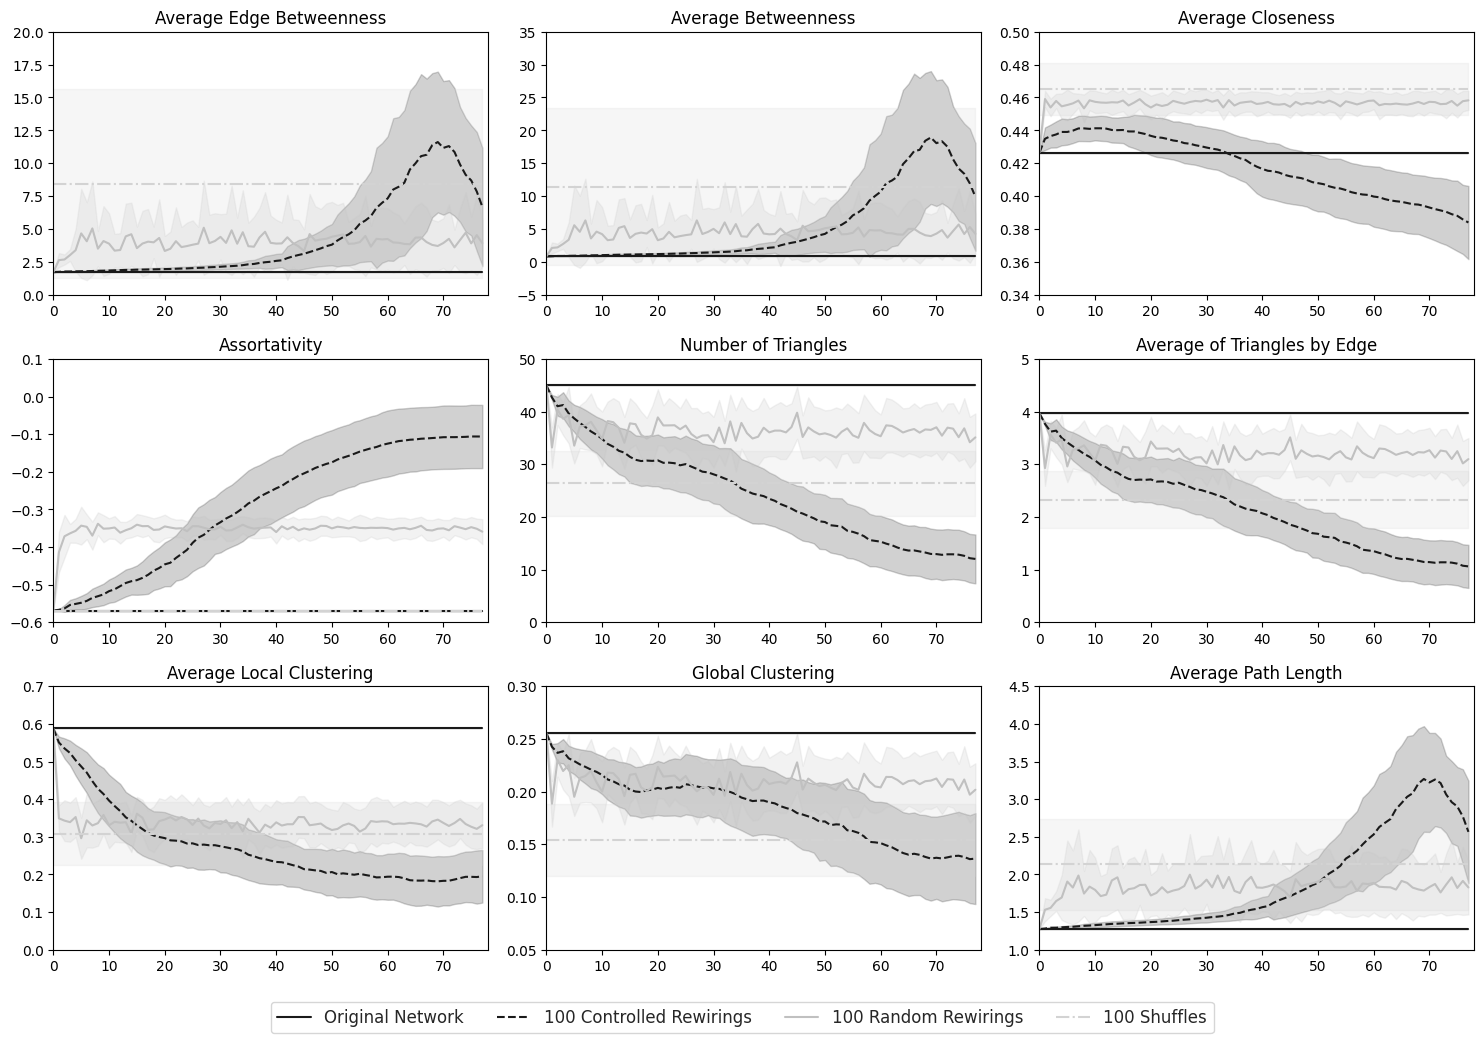

In [15]:
#Plot the charts
PanelPlot(name_network, simulations, rewirings)

### Plot P-values only 

In [16]:
df = pd.read_csv("../data/qap/stats_"+name_network+"_rand_rew_metrics.csv", sep = ',')
df = df.sort_values(by = 'rewirings')
df = df.reset_index(drop=True)

In [17]:
df2 = pd.read_csv("../data/qap/nulldist_"+name_network+"_rand_rew.csv", sep = ',')
null_dist_mat = df2.pivot_table('null_dist', ['rewirings'], 'simulations').values
p_values = np.zeros(null_dist_mat.shape)
for i in range(0,null_dist_mat.shape[0]):
    p_values[i,:] = np.sum(np.abs(null_dist_mat[0:i+1,:]) >= np.abs(null_dist_mat[0,:]),axis = 0) / len(rewirings[0:i+1])

In [18]:
df3 = pd.read_csv("../data/qap/stats_"+name_network+"_shuffle_metrics.csv", sep = ',')
df4 = pd.read_csv("../data/qap/nulldist_"+name_network+"_shuffle.csv", sep = ',')
p_value_shuffle = np.sum(np.abs(df4['null_dist']) >= np.abs(df4['null_dist'][0])) / len(df4['null_dist'])

In [19]:
df5 = pd.read_csv("../data/qap/stats_"+name_network+"_cont_rew_metrics.csv", sep = ',')
df5 = df5.rename(columns={'Unnamed: 0': 'rewirings'})

In [20]:
df6 = pd.read_csv("../data/qap/nulldist_"+name_network+"_cont_rew.csv", sep = ',')
df6 = df6.rename(columns={'Unnamed: 0': 'rewirings'})

In [21]:
null_dist_mat_cont =  df6.to_numpy()
p_values_cont = np.zeros(null_dist_mat_cont.shape)
for i in range(0,null_dist_mat_cont.shape[0]):
    p_values_cont[i,:] = np.sum(np.abs(null_dist_mat_cont[0:i+1,:]) >= np.abs(null_dist_mat_cont[0,:]),axis = 0) / len(null_dist_mat_cont[0:i+1])

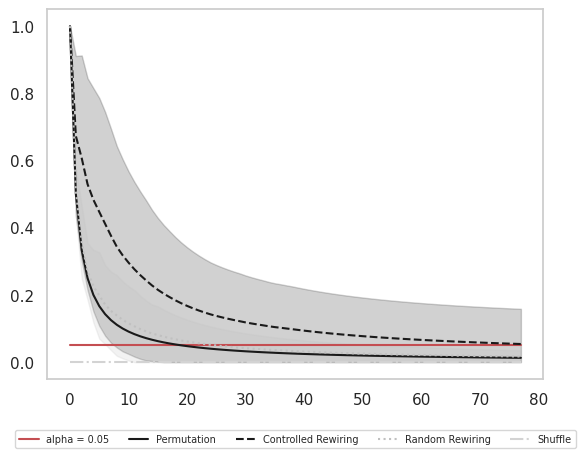

In [22]:
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
N = 100
x = df["rewirings"]
x5 = np.arange(0,network.ecount())
mean_1 = np.repeat(0.05,len(df["rewirings"]))
#std_1 = 3 + np.random.normal(0, .08, N).cumsum()

mean_2 = np.mean(p_values,axis = 1)
std = np.std(p_values,axis = 1)
std_mean = mean_2 - np.std(p_values,axis = 1)
mean_3 = np.repeat(p_value_shuffle,len(df["rewirings"]))
mean_4 = np.repeat(1,len(x))/np.arange(1,len(x)+1)

mean_5 = np.mean(p_values_cont[0:len(df["rewirings"])],axis = 1)
std_5 = np.std(p_values_cont[0:len(df["rewirings"])],axis = 1)

plt.plot(x, mean_1, 'r-', label='alpha = 0.05')
plt.plot(x, mean_4, 'k-', label='Permutation')
plt.plot(x5, mean_5, 'k--', label='Controlled Rewiring')
plt.fill_between(x5, np.maximum(mean_5 - std_5,0), np.minimum(mean_5 + std_5,1), color='k', alpha=0.2)
plt.plot(x, mean_2, color = 'silver', linestyle = ':', label='Random Rewiring')
plt.fill_between(x, np.maximum(mean_2 - std,0), np.minimum(mean_2 + std,1), color='silver', alpha=0.2)
plt.plot(x, mean_3, color = 'lightgrey', linestyle = '-.', label='Shuffle')

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=7)
plt.show()